In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
#import torch.cuda
import random
from itertools import chain as chain
from torch.distributions.multivariate_normal import MultivariateNormal
import math

#conda activate base
cudaOn = False

In [2]:
#Data preparation

In [3]:
tepLoc = "C:/Users/Charlie/Desktop/TEP_Data/"

#tepTrain = tepLoc + "TEP_Faulty_Training.csv"
tepTrain = tepLoc + "TEP_FaultFree_Training.csv"

#tepTest = tepLoc + "TEP_FaultFree_Testing.csv"
tepTest = tepLoc + "TEP_Faulty_Testing.csv"

scaler = MinMaxScaler()

#data = pd.read_csv('c172_file_1.csv')
data = pd.read_csv(tepTrain)
dataTest = pd.read_csv(tepTest)



In [4]:
#lookie = dataTest[dataTest['simulationRun']==112]
#print(lookie[lookie['faultNumber']==5])

In [5]:
data = data.drop('Unnamed: 0',axis=1)
data = data.drop('faultNumber',axis=1)
#data = data.drop('simulationRun',axis=1)
#data = data.drop('sample',axis=1)
data

,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,1,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,1,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,1,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,500,496,0.29325,3640.1,4473.0,9.1949,26.867,42.379,2700.2,75.533,...,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756
249996,500,497,0.29134,3625.7,4506.2,9.2109,26.889,42.291,2700.6,75.935,...,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360
249997,500,498,0.29438,3600.2,4478.3,9.1957,26.820,42.448,2700.3,74.706,...,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344
249998,500,499,0.25269,3683.5,4486.4,9.2832,27.188,42.757,2697.4,75.101,...,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797,39.835,18.512


In [6]:
dataTest = dataTest[dataTest['simulationRun']==60]
faultNumbersT = dataTest.get('faultNumber')
#
dataTest = dataTest.drop('Unnamed: 0',axis=1)
dataTest = dataTest.drop('faultNumber',axis=1)
#dataTest = dataTest.drop('simulationRun',axis=1)
#dataTest = dataTest.drop('sample',axis=1)
#dataTest = data
#dataTest = dataTest.iloc(0)[0:19500] #test A and B
#dataTest = dataTest.iloc(0)[19500:38500] #test C and D
#dataTest = dataTest.iloc(0)[39000:58000]

faultNumbersTest = []
for i in faultNumbersT:
    faultNumbersTest.append(i)

data = data.astype('float64')
dataTest = dataTest.astype('float64')

In [7]:
run_length = 960
#num = 960
for i in range(int(len(faultNumbersTest)/run_length)):
    print(str(i*run_length) + ": " + str(faultNumbersTest[i*run_length]))
#print(faultNumbersTest[10000:10100])

0: 1
960: 2
1920: 3
2880: 4
3840: 5
4800: 6
5760: 7
6720: 8
7680: 9
8640: 10
9600: 11
10560: 12
11520: 13
12480: 14
13440: 15
14400: 16
15360: 17
16320: 18
17280: 19
18240: 20


In [8]:
print(dataTest)
numVariables = 54#52

         simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  \
1132800           60.0     1.0  0.25212   3665.6   4538.2   9.3005   26.596   
1132801           60.0     2.0  0.24987   3671.5   4504.2   9.2820   27.075   
1132802           60.0     3.0  0.25062   3664.7   4495.1   9.3984   26.734   
1132803           60.0     4.0  0.24948   3678.0   4520.5   9.3693   27.112   
1132804           60.0     5.0  0.28200   3708.0   4502.0   9.2449   27.011   
...                ...     ...      ...      ...      ...      ...      ...   
1151995           60.0   956.0  0.24885   3699.1   4522.3   9.3982   26.716   
1151996           60.0   957.0  0.18616   3624.4   4556.8   9.4190   26.863   
1151997           60.0   958.0  0.18621   3632.4   4499.8   9.3068   26.513   
1151998           60.0   959.0  0.24906   3687.0   4552.0   9.3735   26.948   
1151999           60.0   960.0  0.24974   3668.8   4501.2   9.5062   26.726   

         xmeas_6  xmeas_7  xmeas_8  ...   xmv_2   x

In [9]:
#Helper Methods

In [10]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    #make stochastic
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = torch.tensor(x[start:(start+batch_size)]) #!! added tensor line
    #print(batch.shape)
    return batch

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def loss_fn(recon_x, x, mu, logvar):
        #print(recon_x.shape)
        #print(x.shape)
        BCE = F.binary_cross_entropy(recon_x, x)#, size_average=False)
    
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD
    
def tep_testing_stepped(dat,step_size):
    res = []
    ind = 0
    scale = MinMaxScaler().fit(dat)
    dat = pd.DataFrame(scale.transform(dat))
    #print(int((len(data)/step_size)))
    for i in range(int((len(dat)/step_size))):
        if ind + step_size < len(dat):
            step = []
            for j in range(step_size):
              #print(data.iloc(0)[ind])#[ind])
              step.append(dat.iloc(0)[ind])
              ind = ind + 1
            res.append(step)
    return res

In [11]:
#Model

In [50]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()
        #self.rnn = nn.GRU(image_size,image_size,batch_first=True)
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2) #is it saying its getting a mu and a var for each z dim out?
            
            #how can I represent the encoder as a distribution acting as the prior?
        )
        print(z_dim*2)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
        print(image_size)
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        #q = self.recurrent(x)
        #print("--" + str(x.shape))
        h = self.encoder(x)
        #print("--" + str(h.shape))
        mu, logvar = torch.chunk(h, 2, dim=1)
        #print(mu.shape)
        #print(logvar.shape)
        z = self.reparameterize(mu, logvar)
        #print(str(z.shape) + str(" XXX"))
        #print(z)
        #z = z.float()
        z = model(z)
        #print(z)
        tensorZ = z[0]#torch.tensor(z[0])
        #print(str(tensorZ.shape) + str(" YYY"))
        #print(z[0])
        #print("--" + str(self.decoder(tensorZ).shape))

        return self.decoder(tensorZ), mu, logvar
        #return self.decoder(z), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 
        #print("t")
        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        print("x1: " + str(x1.shape))
        #print("x2: " + str(x2.shape))
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)
        #print(z_hat.shape)
        #print("ooooooo")
        #print(z_hat)
        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [51]:
#Model Setup

In [60]:
step_size = 3
batch = 512
index_step_length = numVariables
epochs = 20

num = 10

d = 54
k = 27

base_mu, base_cov = torch.zeros(54), torch.eye(54)

base_mu = torch.nn.parameter.Parameter(to_var(base_mu.double()))
base_cov = torch.nn.parameter.Parameter(to_var(base_cov.double()))
#base_mu = torch.nn.parameter.Parameter(base_mu,requires_grad=True)
#base_cov = torch.nn.parameter.Parameter(base_cov,requires_grad=True)
print(base_mu)
print(base_cov)
base_dist = MultivariateNormal(base_mu, base_cov)
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(data, step_size)
#XX.cuda()
demo = VAE(index_step_length,h_dim=13,z_dim=54)
model = stacked_NVP(d, k, hidden=512,n=num)#hidden -> 512
demo.double()
model.double()
    
#next set of tests should be with n=3, last set was with n=1
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.RMSprop(demo.parameters(), lr=1e-3)
optimizer3 = torch.optim.RMSprop([base_mu,base_cov], lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
#scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer2, 0.999)

if torch.cuda.is_available() & cudaOn:
    demo.cuda()
    print("demo done")
    model.cuda()
    print("model done")

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64,
       requires_grad=True)
108
54


In [61]:
#Model Training

In [62]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(X,batch)
    #print(demo.rnn(b).shape)
    #b = demo.rnn(b)
    #print(range(batch))
    for i in range(batch):
        #localX = torch.tensor(b[i].cuda())
        optimizer.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        #localX = to_var(b[i])
        localX = to_var(torch.tensor(b[i]))
        #print(localX.shape)
        #print(localX.type)
        recon, mu, logvar = demo(localX)
        print(recon)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model and variational approximation, respectively."""

        loss.backward()
        
        optimizer.step()
        optimizer2.step()
        optimizer3.step()
        scheduler.step()
        #scheduler2.step()
        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = abs(torch.mean(localX-recon))

        if idx%step_size == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))

tensor([[ 0.4770, -2.3366,  0.2015, -1.0965,  0.0138,  0.5691,  1.0484,  0.6350,
          0.5002,  0.5973,  0.5511,  0.8635,  0.1120, -0.8902, -0.0285, -1.2166,
         -0.2452, -0.8211, -0.2736,  0.3870, -0.8391,  0.2405,  0.8925,  0.3384,
         -0.6507, -1.2841,  0.0757, -0.1499,  0.5858, -1.8142, -0.6469,  0.2438,
         -0.2332,  1.2824,  0.6189, -0.4385, -0.0579, -0.5556,  0.7731,  1.3920,
         -0.3132, -0.0961,  0.0364,  0.9273, -1.3485, -0.6626, -0.8174,  1.3262,
          1.0694,  0.3464, -0.0541, -0.0149,  0.0604,  0.3965],
        [ 0.7268, -1.5707,  1.0420, -1.4435,  0.4843, -1.9943, -0.8145,  0.1536,
          1.1309,  0.7732, -1.1291,  0.8265,  0.3604, -0.9273,  0.5306,  0.7530,
         -1.9981,  0.5450,  0.5575,  0.5079, -0.6529, -0.3784,  0.4699,  0.9511,
          0.1983, -1.2531, -0.2801,  0.6318,  0.5179, -1.8017, -1.1898,  0.4429,
          1.2912,  1.5408,  0.4589, -2.0283,  0.0222,  0.0158, -0.7348,  0.1074,
         -0.3394, -0.1500,  0.6536, -1.2790, 

C:\Users\Charlie\AppData\Local\Temp/ipykernel_17016/1918419272.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  localX = to_var(torch.tensor(b[i]))


RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -nan(ind) at C:\Users\builder\AppData\Local\Temp\pip-req-build-e5c8dddg\aten\src\THNN/generic/BCECriterion.c:62

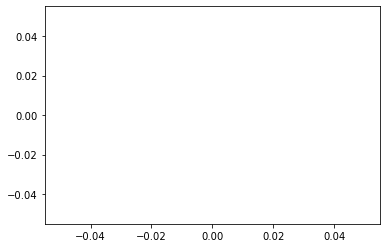

In [23]:
p = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')

In [ ]:
"""
t1 = tep_testing_stepped(dataTest,step_size)
step_start = 0
anomalies = []
y_nomalies = []
county = 0
setNum = 0
for step in t1:
    step = to_var(torch.tensor(step,dtype=torch.float64))
    recon,_,_ = demo(step)
    anom = abs(torch.mean(step-recon))
    anom2 = torch.mean(torch.tensor(faultNumbersTest[county:county+step_size],dtype=torch.float64))
    anomalies.append(anom)
    y_nomalies.append(anom2)
    step_start = step_start + 1
    county = county + step_size
p3 = plt.figure()
plt.plot(anomalies, 'g-')
p4 = plt.figure()
plt.plot(y_nomalies, 'b-')
"""

In [ ]:
loc = "C:/Users/Charlie/Desktop/picsForDemo2/tepGeneratedLast/"

strtOfTwo = int(len(dataTest)/20)
sets = []
runNum = 0 
print(len(faultNumbersTest))

print("////////////////////")
for i in range(20):
    print(str(strtOfTwo*runNum) + " : " + str((strtOfTwo*runNum)+run_length))
    #print(faultNumbersTest[strtOfTwo*runNum])
    dt = dataTest[strtOfTwo*runNum:(strtOfTwo*runNum)+run_length]
    t1 = tep_testing_stepped(dt,step_size)
    sets.append(t1)
    runNum = runNum + 1
print("////////////////////")

setNum = 0
for set in sets:
    setName = "anom" + str(setNum+1) + "Faulty_Flow_166"
    fileLoc = loc + setName + ".png"
    step_start = 0
    anomalies = []
    y_nomalies = []
    vals = []
    pred_vals = []
    county = 0
    #print(type(XX))
    #print(len(XX))
    #print(XX.shape)
    for step in set:
      step = to_var(torch.tensor(step,dtype=torch.float64))
      if True:
          #step = torch.tensor(XX[step_start:step_start+step_size])[0]
          recon,_,_ = demo(step)
          print(recon)
          a = 1
          #b = 1
          for j in range(len(step)):
            a = (step[0][j] - recon[0][j])
            #a = a + (step[0][j] - recon[0][j])
            #b = b * recon[0][j]
          #anom = abs(torch.mean(step-recon))
          #print("-------------: " + str(torch.mean(step-recon)))
          #print(str(a) + ",    " + str(b))
          anom = a
          anom2 = torch.mean(torch.tensor(faultNumbersTest[(setNum*strtOfTwo)+(county*step_size):(setNum*strtOfTwo)+(county*step_size+step_size)],dtype=torch.float64))
          #if county%100 == 0:
            #print("step: " + str(step))
            #print("recon: " + str(recon))
            #print(anom)
          #anomalies.append(torch.tensor(math.sqrt(abs(anom))))
          #anomalies.append(torch.tensor(abs(anom)))
          anomalies.append(torch.tensor(abs(anom)))
          y_nomalies.append(anom2)
          pred_vals.append(torch.mean(recon))
          vals.append(torch.mean(step))
          step_start = step_start + 1
          county = county + 1
    setNum = setNum + 1
    start = 0
    view = []
    max = -99999
    min = 99999
    maxA = -99999
    minA = 99999

    print(len(anomalies))

    for a in anomalies:
        if start+1 < len(anomalies):
            view.append(abs(anomalies[start+1].item() - a.item()))  
            start = start + 1

    for i in range(len(view)):
        j = i + 1
        if view[i] > max:
            max = a.item()
        if view[i] < min:
            min = a.item()
        if i < len(view)-1:
            #print("i: " + str(view[i]))
            #print("j: " + str(view[j]))
            v = abs(view[i]-view[j])
            #print("v: " + str(v))
            if v > maxA:
                maxA = v
            if v < minA:
                minA = v

    print()
    print(max)
    print(maxA)
    print(minA)

    #could get loc min and max given a step size rather than literally between individual points

    #ADD LINEAR REGRESSION LINE
    
    p3 = plt.figure()
    plt.plot(anomalies, 'g-')
    plt.savefig(fileLoc)
    p4 = plt.figure()
    #plt.plot(y_nomalies, 'b-')
    plt.plot(vals, 'b-')
    p5 = plt.figure()
    plt.plot(pred_vals, 'r-')
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")